In [ ]:
from transformers import AutoTokenizer
import torch
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
from generation import speculative_generate, autoregressive_generate
from models import load_models
from nucleus_processor import NucleusProcessor

In [11]:
def compare_methods(
    target,
    drafter,
    text,
    gen_len=100,
    gamma=4,
    temperature=0.6,
    top_p=0.9,
    verbose=False
):
    """
    Compare two text generation methods: speculative decoding and auto-regressive decoding.

    Args:
        target: target model.
        drafter: drafter model.
        text: Input sequence (prompt) of batch size 1.
        gen_len: Maximum length of the generated sequence.
        gamma: Number of drafts generated by the drafter at each step.
        temperature: Temperature for sampling in the logits processor.
        top_p: Nucleus sampling threshold (p).
    """
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(target.name_or_path)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Prepare input IDs
    input_ids = tokenizer(text, return_tensors="pt").input_ids[0].tolist()

    # Configure logits processor for Nucleus Sampling
    logits_processor = NucleusProcessor(temperature=temperature, top_p=top_p)

    # Auto-regressive decoding
    start_ar = time.time()
    output_ids_ar = autoregressive_generate(
        input_ids,
        target,
        logits_processor=logits_processor,
        max_gen_len=gen_len,
        eos_tokens_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
    )
    end_ar = time.time()
    time_ar = end_ar - start_ar
    output_ar = tokenizer.decode(output_ids_ar, skip_special_tokens=True)

    # Speculative decoding
    start_sd = time.time()
    output_ids_sd, alpha = speculative_generate(
        input_ids,
        drafter,
        target,
        logits_processor=logits_processor,
        gamma=gamma,
        max_gen_len=gen_len,
        eos_tokens_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
    )
    end_sd = time.time()
    time_sd = end_sd - start_sd
    output_sd = tokenizer.decode(output_ids_sd, skip_special_tokens=True)

    if verbose:
        print(f"-> Auto-regressive decoding:\n{text}{output_ar}\n")
        print(f"-> Speculative decoding:\n{text}{output_sd}\n")
        print(f"-> Acceptance rate: {alpha:.2%}")
        print(f"-> Auto-regressive decoding time: {time_ar:.4f} sec")
        print(f"-> Speculative decoding time: {time_sd:.4f} sec")
        print(f"-> Speedup factor: {time_ar / time_sd:.2f}x")

    return time_ar / time_sd

## Llama 3.2

In [ ]:
target, drafter = load_models(
    target_model_name="meta-llama/Llama-3.2-3B",
    drafter_model_name="meta-llama/Llama-3.2-1B"
)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [ ]:
compare_methods(
    target=target,
    drafter=drafter,
    text="Paris is known for its rich history and vibrant culture",
    gen_len=500
)

-> Auto-regressive decoding:
Paris is known for its rich history and vibrant culture, but it’s also a city that’s constantly evolving. From its iconic landmarks to its cutting-edge architecture, Paris is a city that never stands still. In this article, we’ll take a look at some of the latest developments in Paris and explore what’s in store for the future of this iconic city.
The latest development in Paris is the completion of the new airport terminal, which is set to open in 2024. The new terminal will be the largest in the city and will include state-of-the-art facilities, including a new runway, a duty-free shopping area, and a range of dining and entertainment options. The new terminal is expected to bring more than 100 million passengers to Paris each year, making it one of the busiest airports in the world.
Another major development in Paris is the ongoing renovation of the Eiffel Tower. The tower has been closed to the public for several years while renovations are carried out,

## GPT-2

In [ ]:
target, drafter = load_models(
    target_model_name="openai-community/gpt2-xl",
    drafter_model_name="openai-community/gpt2"
)

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
compare_methods(
    target=target,
    drafter=drafter,
    text="Paris is known for its rich history and vibrant culture",
    gen_len=500
)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

-> Auto-regressive decoding:
Paris is known for its rich history and vibrant culture. Here, the city of lights is a place of contrasts, where art, music, and the arts are celebrated and embraced. The city is a place of contrasts, where art, music, and the arts are celebrated and embraced.

Paris is known for its rich history and vibrant culture. Here, the city of lights is a place of contrasts, where art, music, and the arts are celebrated and embraced. The city is a place of contrasts, where art, music, and the arts are celebrated and embraced.

Paris is known for its rich history and vibrant culture. Here, the city of lights is a place of contrasts, where art, music, and the arts are celebrated and embraced. The city is a place of contrasts, where art, music, and the arts are celebrated and embraced.

Paris is known for its rich history and vibrant culture. Here, the city of lights is a place of contrasts, where art, music, and the arts are celebrated and embraced. The city is a plac

## BLOOM

In [ ]:
target, drafter = load_models(
    target_model_name="bigscience/bloom-3b",
    drafter_model_name="bigscience/bloom-560m"
)

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/6.01G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
compare_methods(
    target=target,
    drafter=drafter,
    text="The sun dipped below the horizon, casting a golden hue over the tranquil lake. Birds chirped softly in the distance, their melodies blending with the gentle rustling of leaves. A cool breeze swept through the air, carrying with it the faint scent of blooming flowers. As the evening deepened, the stars began to emerge, one by one, painting the sky with their shimmering light. The world seemed to pause, if only for a moment, as nature embraced the serenity of the night",
    gen_len=500
)

-> Auto-regressive decoding:
The sun dipped below the horizon, casting a golden hue over the tranquil lake. Birds chirped softly in the distance, their melodies blending with the gentle rustling of leaves. A cool breeze swept through the air, carrying with it the faint scent of blooming flowers. As the evening deepened, the stars began to emerge, one by one, painting the sky with their shimmering light. The world seemed to pause, if only for a moment, as nature embraced the serenity of the night.
In the middle of the night, the nightingale sang a song of love in the forest. A pretty young lady and a handsome young man stood on a branch, their eyes fixed on each other, their lips twitching in a sweet, passionate kiss. The nightingale stopped singing, and then sang a song of love in the forest. A pretty young lady and a handsome young man stood on a branch, their eyes fixed on each other, their lips twitching in a sweet, passionate kiss. The nightingale stopped singing, and then sang a s

## Experiments

`low_cpu_mem_usage` was None, now default to True since model is quantized.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


Running experiment for gamma = 1
  Speedup: 1.47x, Acceptance Rate: 80.91%
Running experiment for gamma = 2
  Speedup: 7.07x, Acceptance Rate: 52.50%
Running experiment for gamma = 3
  Speedup: 1.29x, Acceptance Rate: 48.28%
Running experiment for gamma = 4
  Speedup: 0.77x, Acceptance Rate: 47.79%
Running experiment for gamma = 5
  Speedup: 1.33x, Acceptance Rate: 37.39%
Running experiment for gamma = 6
  Speedup: 1.30x, Acceptance Rate: 37.74%
Running experiment for gamma = 7
  Speedup: 1.61x, Acceptance Rate: 50.49%
Running experiment for gamma = 8
  Speedup: 1.17x, Acceptance Rate: 30.85%


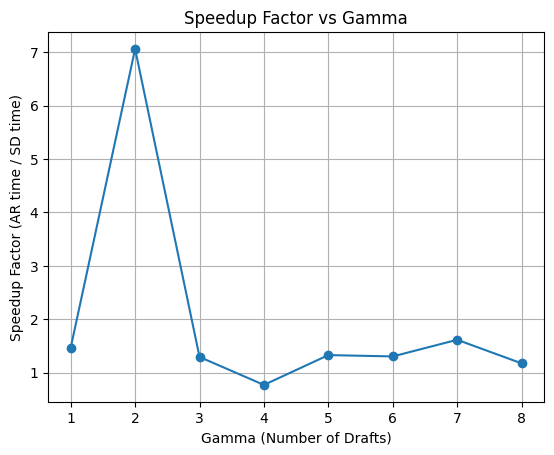

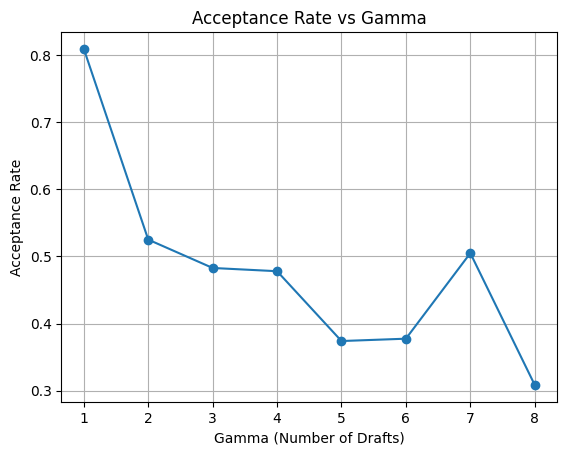

In [ ]:
def compare_methods_return(
    target,
    drafter,
    text,
    gen_len=100,
    gamma=4,
    temperature=0.6,
    top_p=0.9,
):
    tokenizer = AutoTokenizer.from_pretrained(target.name_or_path)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    input_ids = tokenizer(text, return_tensors="pt").input_ids[0].tolist()
    logits_processor = NucleusProcessor(temperature=temperature, top_p=top_p)
    start_ar = time.time()
    output_ids_ar = autoregressive_generate(
        input_ids,
        target,
        logits_processor=logits_processor,
        max_gen_len=gen_len,
        eos_tokens_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
    )
    end_ar = time.time()
    time_ar = end_ar - start_ar
    start_sd = time.time()
    output_ids_sd, alpha = speculative_generate(
        input_ids,
        drafter,
        target,
        logits_processor=logits_processor,
        gamma=gamma,
        max_gen_len=gen_len,
        eos_tokens_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
    )
    end_sd = time.time()
    time_sd = end_sd - start_sd
    speedup = time_ar / time_sd if time_sd > 0 else float('inf')
    output_ar = tokenizer.decode(output_ids_ar, skip_special_tokens=True)
    output_sd = tokenizer.decode(output_ids_sd, skip_special_tokens=True)
    return {
        "auto_output": output_ar,
        "speculative_output": output_sd,
        "time_ar": time_ar,
        "time_sd": time_sd,
        "speedup": speedup,
        "acceptance_rate": alpha
    }

target, drafter = load_models(
    target_model_name="openai-community/gpt2-xl",
    drafter_model_name="openai-community/gpt2"
)

# Experiment settings
text = "Paris is known for its rich history and vibrant culture"
gen_len = 200
gamma_values = list(range(1, 9))  # Testing gamma from 1 to 8
speedup_factors = []
acceptance_rates = []

for gamma in gamma_values:
    print(f"Running experiment for gamma = {gamma}")
    metrics = compare_methods_return(
        target=target,
        drafter=drafter,
        text=text,
        gen_len=gen_len,
        gamma=gamma,
        temperature=0.6,
        top_p=0.9,
    )
    print(f"  Speedup: {metrics['speedup']:.2f}x, Acceptance Rate: {metrics['acceptance_rate']:.2%}")
    speedup_factors.append(metrics["speedup"])
    acceptance_rates.append(metrics["acceptance_rate"])

# Plot Speedup Factor vs Gamma
plt.figure()
plt.plot(gamma_values, speedup_factors, marker='o')
plt.xlabel('Gamma (Number of Drafts)')
plt.ylabel('Speedup Factor (AR time / SD time)')
plt.title('Speedup Factor vs Gamma')
plt.grid(True)
plt.show()

# Plot Acceptance Rate vs Gamma
plt.figure()
plt.plot(gamma_values, acceptance_rates, marker='o')
plt.xlabel('Gamma (Number of Drafts)')
plt.ylabel('Acceptance Rate')
plt.title('Acceptance Rate vs Gamma')
plt.grid(True)
plt.show()

`low_cpu_mem_usage` was None, now default to True since model is quantized.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


Running experiment for temperature = 0.4, top_p = 0.8
  Speedup: 1.19x, Acceptance Rate: 51.55%
Running experiment for temperature = 0.4, top_p = 0.9
  Speedup: 1.70x, Acceptance Rate: 56.56%
Running experiment for temperature = 0.4, top_p = 0.95
  Speedup: 2.03x, Acceptance Rate: 75.25%
Running experiment for temperature = 0.6, top_p = 0.8
  Speedup: 1.56x, Acceptance Rate: 53.57%
Running experiment for temperature = 0.6, top_p = 0.9
  Speedup: 1.36x, Acceptance Rate: 44.06%
Running experiment for temperature = 0.6, top_p = 0.95
  Speedup: 1.35x, Acceptance Rate: 42.81%
Running experiment for temperature = 0.8, top_p = 0.8
  Speedup: 1.48x, Acceptance Rate: 44.88%
Running experiment for temperature = 0.8, top_p = 0.9
  Speedup: 1.57x, Acceptance Rate: 52.14%
Running experiment for temperature = 0.8, top_p = 0.95
  Speedup: 1.27x, Acceptance Rate: 37.97%
Running experiment for temperature = 1.0, top_p = 0.8
  Speedup: 2.94x, Acceptance Rate: 40.15%
Running experiment for temperature = 

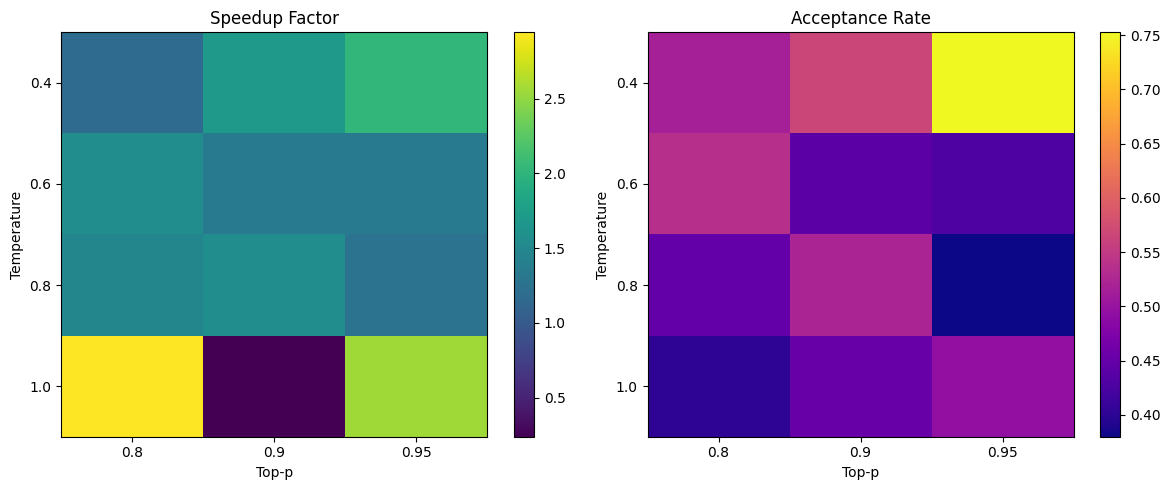

In [ ]:
# Define the grid for temperature and top-p values
temperature_values = [0.4, 0.6, 0.8, 1.0]
top_p_values = [0.8, 0.9, 0.95]

speedup_matrix = np.zeros((len(temperature_values), len(top_p_values)))
acceptance_matrix = np.zeros((len(temperature_values), len(top_p_values)))

target, drafter = load_models(
    target_model_name="openai-community/gpt2-xl",
    drafter_model_name="openai-community/gpt2"
)

text = "Paris is known for its rich history and vibrant culture"
gen_len = 200
gamma = 4 # fixed gamma for this experiment

# Loop over temperatures and top_p values
for i, temp in enumerate(temperature_values):
    for j, top_p in enumerate(top_p_values):
        print(f"Running experiment for temperature = {temp}, top_p = {top_p}")
        metrics = compare_methods_return(
            target=target,
            drafter=drafter,
            text=text,
            gen_len=gen_len,
            gamma=gamma,
            temperature=temp,
            top_p=top_p,
        )
        speedup_matrix[i, j] = metrics["speedup"]
        acceptance_matrix[i, j] = metrics["acceptance_rate"]
        print(f"  Speedup: {metrics['speedup']:.2f}x, Acceptance Rate: {metrics['acceptance_rate']:.2%}")

# Create heatmaps for visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap for Speedup Factor
im1 = ax[0].imshow(speedup_matrix, cmap='viridis', aspect='auto')
ax[0].set_xticks(np.arange(len(top_p_values)))
ax[0].set_yticks(np.arange(len(temperature_values)))
ax[0].set_xticklabels(top_p_values)
ax[0].set_yticklabels(temperature_values)
ax[0].set_xlabel("Top-p")
ax[0].set_ylabel("Temperature")
ax[0].set_title("Speedup Factor")
fig.colorbar(im1, ax=ax[0])

# Heatmap for Acceptance Rate
im2 = ax[1].imshow(acceptance_matrix, cmap='plasma', aspect='auto')
ax[1].set_xticks(np.arange(len(top_p_values)))
ax[1].set_yticks(np.arange(len(temperature_values)))
ax[1].set_xticklabels(top_p_values)
ax[1].set_yticklabels(temperature_values)
ax[1].set_xlabel("Top-p")
ax[1].set_ylabel("Temperature")
ax[1].set_title("Acceptance Rate")
fig.colorbar(im2, ax=ax[1])

plt.tight_layout()
plt.show()

## Dynamic γ

In [ ]:
@torch.no_grad()
def speculative_generate_dynamic(
    inputs,
    drafter,
    target,
    initial_gamma=5,
    gamma_min=1,
    gamma_max=8,
    gamma_increase_threshold=0.9,  # if acceptance ratio > 90%, try increasing gamma
    gamma_decrease_threshold=0.5,  # if acceptance ratio < 50%, try decreasing gamma
    logits_processor=NucleusProcessor(),
    max_gen_len=40,
    eos_tokens_id=1,
    pad_token_id=0,
    skip_sample_adjustment=False,
    first_target=True,
):
    # Initialize caches and input
    drafter_cache, target_cache = None, None
    list_tokens_id = [eos_tokens_id] if not isinstance(eos_tokens_id, list) else eos_tokens_id
    stop_tokens = torch.tensor(list_tokens_id, dtype=torch.long, device=target.device).unsqueeze(1)
    total_drafts_accepted, total_drafts_speculated = 0.0, 0.0
    vocabulary_size = target.config.vocab_size
    prompt_len = len(inputs)
    max_seq_length = (
        target.config.max_position_embeddings
        if hasattr(target.config, "max_position_embeddings")
        else (
            target.config.max_context_length
            if hasattr(target.config, "max_context_length")
            else 1024
        )
    )
    total_len = min(max_seq_length, prompt_len + max_gen_len)
    input_ids = torch.full((1, total_len), pad_token_id, dtype=torch.long, device=target.device)
    input_ids[0, :prompt_len] = torch.tensor(inputs, dtype=torch.long, device=target.device)
    current_position = prompt_len

    # Set the dynamic gamma value
    gamma_current = initial_gamma

    if first_target:
        Mp = target(
            input_ids=input_ids[..., :current_position],
            past_key_values=target_cache,
            use_cache=False,
        )
        target_cache = Mp.past_key_values
        p_p = logits_processor(Mp.logits[..., -1, :])
        t = logits_processor.sample(p_p)
        input_ids[0, current_position] = t
        current_position += 1
        if torch.isin(t, stop_tokens):
            return input_ids[0, prompt_len:current_position].tolist(), 0

    while current_position < total_len:
        # Use the dynamic gamma for this iteration
        corrected_gamma = min(gamma_current, total_len - current_position - 1)
        q = torch.zeros((1, corrected_gamma, vocabulary_size), device=target.device)
        input_ids = input_ids.to(drafter.device)
        # Generate drafts using the current gamma
        for k in range(corrected_gamma):
            Mq = drafter(
                input_ids=input_ids[..., : current_position + k],
                past_key_values=drafter_cache,
                use_cache=False
            )
            drafter_cache = Mq.past_key_values
            draft_logits = Mq.logits[..., -1, :]
            draft_probs = logits_processor(draft_logits)
            q[0, k] = draft_probs.to(target.device)
            xi = logits_processor.sample(draft_probs)
            input_ids[0, current_position + k] = xi

        total_drafts_speculated += corrected_gamma
        input_ids = input_ids.to(target.device)
        Mp = target(
            input_ids=input_ids[..., : current_position + corrected_gamma],
            past_key_values=target_cache,
            use_cache=False
        )
        target_cache = Mp.past_key_values
        draft_logits = Mp.logits[..., current_position - 1 : current_position + corrected_gamma - 1, :]
        p = logits_processor(draft_logits)
        r = torch.rand(corrected_gamma, device=target.device)
        n = corrected_gamma
        # Determine number of accepted drafts in this iteration
        for i in range(corrected_gamma):
            if r[i] > (p / q)[0, i, input_ids[0, current_position + i]]:
                n = i
                break
        total_drafts_accepted += n

        # Compute the acceptance ratio for this iteration and update gamma dynamically
        current_acceptance_ratio = n / corrected_gamma if corrected_gamma > 0 else 0
        if current_acceptance_ratio > gamma_increase_threshold:
            gamma_current = min(gamma_current + 1, gamma_max)
        elif current_acceptance_ratio < gamma_decrease_threshold:
            gamma_current = max(gamma_current - 1, gamma_min)
        # (Otherwise, leave gamma_current unchanged)

        stop_locations = torch.nonzero(
            torch.eq(input_ids[..., current_position : current_position + n], stop_tokens)
        )
        if stop_locations.shape[0] > 0:
            stop_location = stop_locations[0, 1].item()
            return (
                input_ids[0, prompt_len : current_position + stop_location + 1].tolist(),
                total_drafts_accepted / total_drafts_speculated,
            )
        if n == corrected_gamma:
            p_p = Mp.logits[..., current_position + corrected_gamma - 1, :]
            p_p = logits_processor(p_p)
        else:
            if not skip_sample_adjustment:
                p_p = max_fn(p[..., n, :] - q[0, n, :])
            else:
                p_p = p[..., n, :]
        x = logits_processor.sample(p_p)
        input_ids[0, current_position + n : current_position + corrected_gamma] = pad_token_id
        input_ids[0, current_position + n] = x
        current_position += n + 1
        if torch.isin(x, stop_tokens):
            return (
                input_ids[0, prompt_len:current_position].tolist(),
                total_drafts_accepted / total_drafts_speculated,
            )
    return input_ids[0, prompt_len:].tolist(), total_drafts_accepted / total_drafts_speculated

def compare_methods_dynamic_return(
    target,
    drafter,
    text,
    gen_len=100,
    static_gamma=5,
    dynamic_initial_gamma=5,
    temperature=0.6,
    top_p=0.9,
):
    tokenizer = AutoTokenizer.from_pretrained(target.name_or_path)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    input_ids = tokenizer(text, return_tensors="pt").input_ids[0].tolist()
    logits_processor = NucleusProcessor(temperature=temperature, top_p=top_p)

    # Auto-regressive decoding
    start_ar = time.time()
    output_ids_ar = autoregressive_generate(
        input_ids,
        target,
        logits_processor=logits_processor,
        max_gen_len=gen_len,
        eos_tokens_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
    )
    end_ar = time.time()
    time_ar = end_ar - start_ar

    # Speculative decoding with static gamma
    start_static = time.time()
    output_ids_static, alpha_static = speculative_generate(
        input_ids,
        drafter,
        target,
        gamma=static_gamma,
        logits_processor=logits_processor,
        max_gen_len=gen_len,
        eos_tokens_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
    )
    end_static = time.time()
    time_static = end_static - start_static

    # Speculative decoding with dynamic gamma
    start_dynamic = time.time()
    output_ids_dynamic, alpha_dynamic = speculative_generate_dynamic(
        input_ids,
        drafter,
        target,
        initial_gamma=dynamic_initial_gamma,
        logits_processor=logits_processor,
        max_gen_len=gen_len,
        eos_tokens_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
    )
    end_dynamic = time.time()
    time_dynamic = end_dynamic - start_dynamic

    speedup_static = time_ar / time_static if time_static > 0 else float('inf')
    speedup_dynamic = time_ar / time_dynamic if time_dynamic > 0 else float('inf')

    return {
        "auto_output": tokenizer.decode(output_ids_ar, skip_special_tokens=True),
        "static_output": tokenizer.decode(output_ids_static, skip_special_tokens=True),
        "dynamic_output": tokenizer.decode(output_ids_dynamic, skip_special_tokens=True),
        "time_ar": time_ar,
        "time_static": time_static,
        "time_dynamic": time_dynamic,
        "speedup_static": speedup_static,
        "speedup_dynamic": speedup_dynamic,
        "acceptance_rate_static": alpha_static,
        "acceptance_rate_dynamic": alpha_dynamic,
    }

In [ ]:
target, drafter = load_models(
    target_model_name="openai-community/gpt2-xl",
    drafter_model_name="openai-community/gpt2"
)

text = "Paris is known for its rich history and vibrant culture"
gen_len = 200

metrics = compare_methods_dynamic_return(
    target=target,
    drafter=drafter,
    text=text,
    gen_len=gen_len,
    static_gamma=5,
    dynamic_initial_gamma=5,
    temperature=0.6,
    top_p=0.9,
)

print("=== Auto-regressive decoding ===")
print(f"Output: {metrics['auto_output']}")
print(f"Time: {metrics['time_ar']:.4f} sec")
print("\n=== Speculative decoding with static gamma ===")
print(f"Output: {metrics['static_output']}")
print(f"Acceptance Rate: {metrics['acceptance_rate_static']:.2%}")
print(f"Time: {metrics['time_static']:.4f} sec")
print(f"Speedup Factor: {metrics['speedup_static']:.2f}x")
print("\n=== Speculative decoding with dynamic gamma ===")
print(f"Output: {metrics['dynamic_output']}")
print(f"Acceptance Rate: {metrics['acceptance_rate_dynamic']:.2%}")
print(f"Time: {metrics['time_dynamic']:.4f} sec")
print(f"Speedup Factor: {metrics['speedup_dynamic']:.2f}x")

`low_cpu_mem_usage` was None, now default to True since model is quantized.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


=== Auto-regressive decoding ===
Output: , but it's also home to some of the world's most famous museums. The Louvre in Paris is one of the most famous museums in the world, and is the oldest surviving museum in the world. The Museum of Natural History is another of the world's most important museums. The Arc de Triomphe is one of the most recognizable landmarks in Paris, and is also the centerpiece of the city's most visited tourist attraction, the Eiffel Tower.

Paris is often referred to as "the city of light", because of the many lights that illuminate the city, and the unique color of its buildings. Paris has a vibrant nightlife, and its nightlife is often described as lively, lively, and lively. The Parisian nightlife is known for its live entertainment, with many of the most popular bars and clubs located in the center of the city. There are also many famous nightclubs located throughout the city. The nightlife in Paris is known for its variety, with
Time: 30.0251 sec

=== Specu

## WikiText

In [17]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
dataset = dataset.filter(lambda x: len(x['text'].strip()) > 0).shuffle(seed=42)
dataset = dataset.select(range(10))

In [10]:
target, drafter = load_models(
    target_model_name="openai-community/gpt2-xl",
    drafter_model_name="openai-community/gpt2"
)

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

### γ vs Speedup

In [19]:
mean_speedups = []

for gamma in range(1, 10):
    speedups = []

    for example in tqdm(dataset, desc=f"Processing gamma={gamma}", unit="text"):
        text = example['text']

        speedup = compare_methods(
            target=target,
            drafter=drafter,
            text=text,
            gamma=gamma,
            gen_len=150
        )

        speedups.append(speedup)

    mean_speedup = sum(speedups) / len(speedups) if speedups else 0
    mean_speedups.append(mean_speedup)

Processing gamma=9: 100%|██████████| 10/10 [06:41<00:00, 40.11s/text]


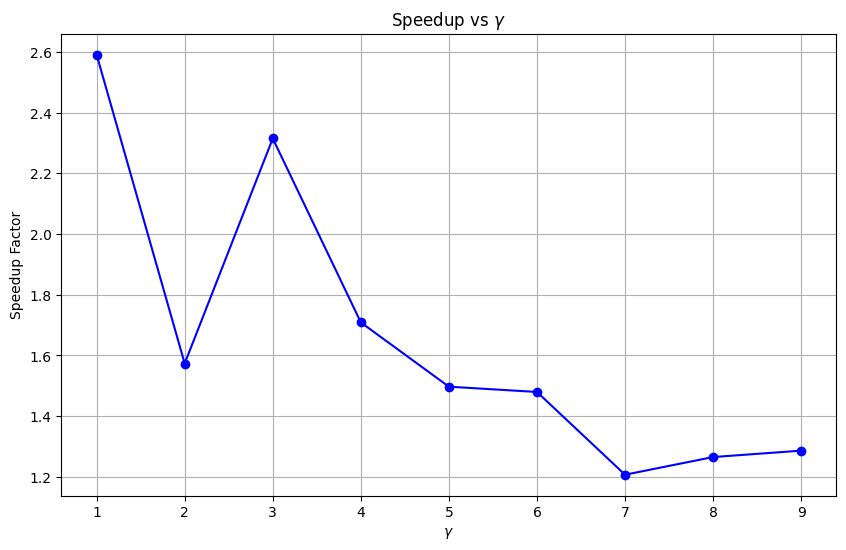

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), mean_speedups, marker='o', linestyle='-', color='b')
plt.title(r"Speedup vs $\gamma$")
plt.xlabel(r"$\gamma$")
plt.ylabel("Speedup Factor")
plt.grid(True)
plt.show()